In [ ]:
import numpy as np
import random
import torch
import torchvision
import matplotlib.pyplot as plt

def set_device():
  device = "cude" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
    "if possible, in the menu under `Runtime` ->"
    "`Change runtime type.` select `GPU`")
  else:
    print("GPU is enable in this notebook")

  return device

# set global varaiables
DEVICE = set_device()
DEVICE

'cpu'

In [ ]:
%load_ext autoreload
%autoreload

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm


# Import functions from github
!git clone https://github.com/RobertRosenbaum/ConductanceBasedBalance.git
from ConductanceBasedBalance.utils import EIFNetworkCurrentPlusFree, EIFNetworkCondPlusFree, GetBlockErdosRenyi, PoissonProcess

Cloning into 'ConductanceBasedBalance'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 1), reused 19 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 290.75 KiB | 2.69 MiB/s, done.
Resolving deltas: 100% (1/1), done.


** Review Data Cleaning **

In [ ]:
#pip install nltk

In [ ]:
# import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!ls "Investor CDP 2010_Public Data(9.csv"
#df = pd.read_csv("My Drive/data/Investor CDP 2010_Public Data(9.csv", index_col=0)

Mounted at /content/drive


In [ ]:
# load data
raw_df = pd.read_csv("/content/drive/MyDrive/CDP Project/Data/CDP2010.csv", encoding='cp1252')
print(raw_df.shape)

# drop NaNs
df1 = raw_df.dropna() # about half quantity of the rows are useless!
print(df1.shape)
df1.iloc[:,6]

(4835, 7)
(2884, 7)


,9.7. Please use the table below to describe your company’s actions to reduce its GHG emissions.\n\n9.7 C1. \n1. Actions - please describe
1,Stopping of one BFW pump of UB8/9
2,Air fin fan blades replacement with FRP
3,Automatic combusion control for DHDS charge he...
4,LP Steam APH for CDU2 charge heaters
5,DEA Flow optimization to Fuel Gas Amine Absorp...
...,...
4817,Through the firm’s multi-year alliance with E+...
4820,Development and rollout of online sustainabili...
4822,"Every year, we introduce energy-saving equipme..."
4826,Vent gas capture in Canadian heavy oil operations


In [ ]:
#pip install nltk
nltk.download('all')
# nltk.download('punkt')
# nltk.download('stopwords')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
# create preprocess_text function: to clear out words like a, the, this, that, is, of, etc.
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text
# apply the function df
# df['reviewText'] = df['reviewText'].apply(preprocess_text)
# df

df1['Text'] = df1.iloc[:,6].apply(preprocess_text)

df1

<ipython-input-10-73e256227a34>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Text'] = df1.iloc[:,6].apply(preprocess_text)


,Organisation,Country,Access,Primary Expansion,Secondary Expansions,Complexity,9.7. Please use the table below to describe your company’s actions to reduce its GHG emissions.\n\n9.7 C1. \n1. Actions - please describe,Text
1,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Stopping of one BFW pump of UB8/9,stopping one bfw pump ub8/9
2,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Air fin fan blades replacement with FRP,air fin fan blade replacement frp
3,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Automatic combusion control for DHDS charge he...,automatic combusion control dhds charge heater
4,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,LP Steam APH for CDU2 charge heaters,lp steam aph cdu2 charge heater
5,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,DEA Flow optimization to Fuel Gas Amine Absorp...,dea flow optimization fuel gas amine absorptio...
...,...,...,...,...,...,...,...,...
4817,Goldman Sachs Group Inc.,USA,Public,FTSE 600,FTSE All-World 800; Global 500; S&P 500; FTSE ...,Long,Through the firm’s multi-year alliance with E+...,"firm ’ multi-year alliance e+co , not-for-prof..."
4820,Intercontinental Hotels Group,United Kingdom,Public,FTSE 600,Mayday; FTSE 100; FTSE 350,Long,Development and rollout of online sustainabili...,development rollout online sustainability tool...
4822,Mitsubishi Heavy Industries,Japan,Public,Japan 500,FTSE All-World 800,Long,"Every year, we introduce energy-saving equipme...","every year , introduce energy-saving equipment..."
4826,Nexen Inc.,Canada,Public,Canada 200,Bonds 180; FTSE All-World 800,Long,Vent gas capture in Canadian heavy oil operations,vent gas capture canadian heavy oil operation


In [ ]:
# Sample DataFrame
import string
# Remove punctuation from the 'Text' column
df1['Text'] = df1['Text'].str.replace(f"[{string.punctuation}]", "", regex=True)

df1

<ipython-input-11-62b282711caf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Text'] = df1['Text'].str.replace(f"[{string.punctuation}]", "", regex=True)


,Organisation,Country,Access,Primary Expansion,Secondary Expansions,Complexity,9.7. Please use the table below to describe your company’s actions to reduce its GHG emissions.\n\n9.7 C1. \n1. Actions - please describe,Text
1,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Stopping of one BFW pump of UB8/9,stopping one bfw pump ub89
2,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Air fin fan blades replacement with FRP,air fin fan blade replacement frp
3,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Automatic combusion control for DHDS charge he...,automatic combusion control dhds charge heater
4,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,LP Steam APH for CDU2 charge heaters,lp steam aph cdu2 charge heater
5,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,DEA Flow optimization to Fuel Gas Amine Absorp...,dea flow optimization fuel gas amine absorptio...
...,...,...,...,...,...,...,...,...
4817,Goldman Sachs Group Inc.,USA,Public,FTSE 600,FTSE All-World 800; Global 500; S&P 500; FTSE ...,Long,Through the firm’s multi-year alliance with E+...,firm ’ multiyear alliance eco notforprofit in...
4820,Intercontinental Hotels Group,United Kingdom,Public,FTSE 600,Mayday; FTSE 100; FTSE 350,Long,Development and rollout of online sustainabili...,development rollout online sustainability tool...
4822,Mitsubishi Heavy Industries,Japan,Public,Japan 500,FTSE All-World 800,Long,"Every year, we introduce energy-saving equipme...",every year introduce energysaving equipment p...
4826,Nexen Inc.,Canada,Public,Canada 200,Bonds 180; FTSE All-World 800,Long,Vent gas capture in Canadian heavy oil operations,vent gas capture canadian heavy oil operation


In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#creating a new column in the dataframe that stores a boolean value whether that row is a duplicate or not
df1['dup'] = df1.duplicated(subset=None, keep='first')

#checking how many duplicates there were by counding the True and False values in that column
df1['dup'].value_counts() # about 5% of the dataset are duplicates. Let's delete them
df1.head()
# let's write the data into a new dataframe, only keeping the lines where the value for "dup" is False
df1 = df1[df1['dup'] == False]
print(df1.shape)

del df1['dup'] # deleting "dup" column since we don't need ot anymore
df1

(2872, 9)


,Organisation,Country,Access,Primary Expansion,Secondary Expansions,Complexity,9.7. Please use the table below to describe your company’s actions to reduce its GHG emissions.\n\n9.7 C1. \n1. Actions - please describe,Text
1,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Stopping of one BFW pump of UB8/9,stopping one bfw pump ub89
2,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Air fin fan blades replacement with FRP,air fin fan blade replacement frp
3,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,Automatic combusion control for DHDS charge he...,automatic combusion control dhds charge heater
4,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,LP Steam APH for CDU2 charge heaters,lp steam aph cdu2 charge heater
5,Bharat Petroleum Corporation,India,Public,India 200,Emerging Markets 800,Long,DEA Flow optimization to Fuel Gas Amine Absorp...,dea flow optimization fuel gas amine absorptio...
...,...,...,...,...,...,...,...,...
4817,Goldman Sachs Group Inc.,USA,Public,FTSE 600,FTSE All-World 800; Global 500; S&P 500; FTSE ...,Long,Through the firm’s multi-year alliance with E+...,firm ’ multiyear alliance eco notforprofit in...
4820,Intercontinental Hotels Group,United Kingdom,Public,FTSE 600,Mayday; FTSE 100; FTSE 350,Long,Development and rollout of online sustainabili...,development rollout online sustainability tool...
4822,Mitsubishi Heavy Industries,Japan,Public,Japan 500,FTSE All-World 800,Long,"Every year, we introduce energy-saving equipme...",every year introduce energysaving equipment p...
4826,Nexen Inc.,Canada,Public,Canada 200,Bonds 180; FTSE All-World 800,Long,Vent gas capture in Canadian heavy oil operations,vent gas capture canadian heavy oil operation


In [ ]:
# Data Explainary Analysis

first_10 = df1['Country'].value_counts()[:10]
print(first_10.mean()) #mean incidents per year of 10 biggest countries

print(first_10.std())
#standard deviation

231.4
200.79796369042748


<Axes: xlabel='Country'>

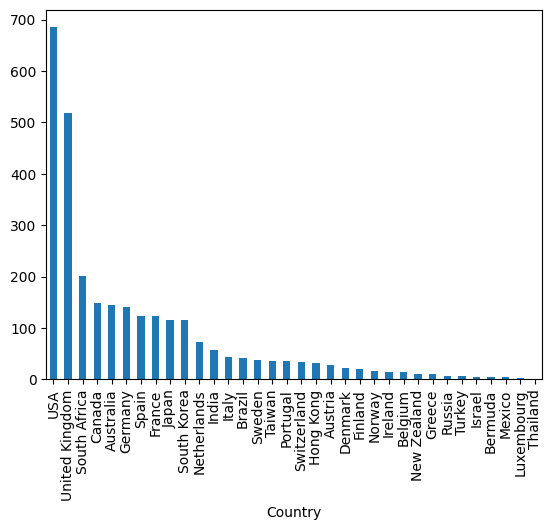

In [ ]:
df1['Country'].value_counts().plot.bar()

In [ ]:
df1['Country'].value_counts()[:10]

,count
Country,
USA,685
United Kingdom,519
South Africa,202
Canada,148
Australia,144
Germany,140
Spain,123
France,123
Japan,115


In [ ]:
#top 5
print(df1['Country'].value_counts()[:10])
sum(df1['Country'].value_counts()[:10])

Country
USA               685
United Kingdom    519
South Africa      202
Canada            148
Australia         144
Germany           140
Spain             123
France            123
Japan             115
South Korea       115
Name: count, dtype: int64


2314

** Text Count**

In [ ]:
from collections import Counter

split_it = df1["Text"][4817].split()
print(split_it)
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_it)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(5)

print(most_occur)

['firm', '’', 'multiyear', 'alliance', 'eco', 'notforprofit', 'invests', 'clean', 'energy', 'business', 'developing', 'country', 'entered', 'transaction', 'purchase', '50000', 'gold', 'standard', 'verified', 'emission', 'reduction', 'vers', 'vers', 'generated', 'manufacture', 'energyefficient', 'cooking', 'stove', 'local', 'artisan', 'manufacturer', 'toyola', 'ghana', 'katene', 'mali', 'stove', '40', 'percent', 'efficient', 'traditional', 'stove', 'used', 'region', 'greatly', 'reduces', 'amount', 'charcoal', 'necessary', 'cook', 'turn', 'reduces', 'carbon', 'dioxide', 'emission', 'deforestation', 'improves', 'indoor', 'air', 'quality', 'provides', 'saving', 'family', 'fuel', 'expense', 'carbon', 'credit', 'local', 'manufacturer', 'expect', 'expand', 'business', 'thereby', 'increasing', 'direct', 'indirect', 'job', 'helping', 'promote', 'sustainable', 'economic', 'development', 'region']
[('stove', 3), ('business', 2), ('emission', 2), ('vers', 2), ('local', 2)]


In [ ]:
# prompt: Aggregate all the text from the country USA in df1 and get the most common word
from collections import Counter # Make sure to import Counter

# Assuming df1 is already defined as in the provided code.

def most_common_word_by_country(df, country):
    """
    Aggregates text from a specified country, preprocesses it, and finds the most common word.
    """
    # Filter data for the specified country
    country_df = df[df['Country'] == country]

    if country_df.empty:
        return "No data found for this country."

    # Combine all text data for the country
    all_text = ' '.join(country_df['Text'])

    # Tokenize the combined text
    tokens = word_tokenize(all_text.lower())

    # Remove stop words and punctuation
    stop_words = set(STOPWORDS)
    filtered_tokens = [w for w in tokens if w not in stop_words and w.isalnum()]

    # Count word frequencies
    word_counts = Counter(filtered_tokens)

    # Find the most common word
    if word_counts:
        most_common = word_counts.most_common(2)
        string_ret_f = most_common[0][0]
        string_ret_s = most_common[1][0]
        return string_ret_f[0].upper() + string_ret_f[1:]+" ; "+string_ret_s[0].upper() + string_ret_s[1:]
    else:
        return "No words found after preprocessing."

# Example usage:
most_common_usa = most_common_word_by_country(df1, 'Russia')
print(f"The most common word in text from USA is: {most_common_usa}")

The most common word in text from USA is: Gas ; Field


In [ ]:
import plotly.graph_objects as go

# Specific countries with their coordinates and colors
countries = [
    {"name":most_common_word_by_country(df1, 'USA'), "lat": 37.0902, "lon": -95.7129, "color": "blue"},
    {"name": most_common_word_by_country(df1, "United Kingdom"), "lat": 55.3781, "lon": -3.4360, "color": "green"},
    {"name": most_common_word_by_country(df1, "South Africa"), "lat": -30.5595, "lon": 22.9375, "color": "red"},
    {"name":most_common_word_by_country(df1, "Canada") , "lat": 56.1304, "lon": -106.3468, "color": "purple"},
    {"name": most_common_word_by_country(df1, "Brazil"), "lat": -14.2350, "lon": -51.9253,"color": "sandybrown"},
     {"name":most_common_word_by_country(df1, "India") , "lat": 20.5937, "lon": 78.9629, "color": "brown"},
     {"name": most_common_word_by_country(df1, "Russia"), "lat": 61.5240, "lon": 105.3188, "color": "yellow"},
    {"name": most_common_word_by_country(df1, "Australia"), "lat": -25.2744, "lon": 133.7751, "color": "orange"},
    # {"name": "Germany", "lat": 51.1657, "lon": 10.4515, "color": "brown"},
    # {"name": "Spain", "lat": 40.4637, "lon": -3.7492, "color": "pink"},
    # {"name": "France", "lat": 46.6034, "lon": 1.8883, "color": "yellow"},
    {"name": most_common_word_by_country(df1, "Japan"), "lat": 36.2048, "lon": 138.2529, "color": "black"},
    # {"name": "South Korea", "lat": 35.9078, "lon": 127.7669, "color": "magenta"}
]

# Create the layout for the map
layout = go.Layout(
    geo=dict(
        # projection=dict(type='orthographic'),  # orthographic projection
        projection=dict(type='equirectangular'),  # orthographic projection
        showland=True,
        landcolor="white",
        # coastlinecolor="red",
        showocean=True,
        coastlinewidth=0.1,
        oceancolor="LightBlue",
        # showlakes=True,
        # lakecolor="navy",
        # showrivers=True,
        # rivercolor="blue",
        showcountries=True,
        countrycolor="gray",
        # lonaxis=dict(showgrid=True, gridwidth=0.5),
        # lataxis=dict(showgrid=True, gridwidth=0.5)
    ),
    title="Orthographic Earth Mapping"
)

# Create Scattergeo plot with country names, colors, and Roboto font style
data = [
    go.Scattergeo(
        lon=[country['lon'] for country in countries],
        lat=[country['lat'] for country in countries],
        text=[country['name'] for country in countries],
        mode='text',  # Ensures both text and markers are displayed
        marker=dict(
            size=10,  # Marker size, make them visible
            color=[country['color'] for country in countries]  # Different colors for each country
        ),
        textfont=dict(
            family="Roboto, Bold",  # Set the text font to Roboto
            size=14,          # You can adjust the text size if needed
            color=[country['color'] for country in countries]  # Different colors for text
        ),
    )
]

# Create the figure and show it
fig = go.Figure(data=data, layout=layout)
fig.show()